# Data calibration
In this notebook, we demonstrate the data calibration, which aligns the real world measurement data with the synthetic data.
This is done solely with information extracted from normal data, that is, data without any defect. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/data_calibration.ipynb)

In [1]:
random_state = 42

In [2]:
import sys
import os
import time
import glob
from pathlib import Path
import sklearn
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets


# initialize environment, paths, etc...
IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    !pip install -r /content/structural_health_monitoring/requirements.txt
    
    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if(pd.__version__ != '1.4.2'):
      print('Stopping RUNTIME! Please run again to finish installation.')
      os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0,"../src")
    
    
sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [3]:
#...and download raw data if not already downloaded
from data_utils import init_data, load_raw_specs
init_data(syn_data_path=SYN_DATA_PATH, real_data_path=REAL_DATA_PATH)

from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_cv_indices,
    plot_embedding_targets,
    init_plotting,
    plot_classwise_dist,
    plot_classwise_kde,
)

# configure fonts, etc...
init_plotting()

time passed: 4.70 s
downloading synthetic data successful: True
time passed: 1.81 s
downloading real world data successful: True


# Data Loading

In [4]:
file_names = list(SYN_DATA_PATH.glob('**/*.csv'))

# cache file for faster data loading on later iterations
pickle_name = Path(SYN_DATA_PATH, 'raw_specs.pkl')

In [5]:
%%time

df_syn = load_raw_specs(file_names=file_names, cache_file=pickle_name)

df_syn.head()

CPU times: total: 31.2 ms
Wall time: 37.9 ms


,spec_0,spec_1,spec_2,spec_3,spec_4,spec_5,spec_6,spec_7,spec_8,spec_9,...,spec_793,spec_794,spec_795,spec_796,spec_797,spec_798,spec_799,spec_800,y_radius,file
0,169595.281250,8587.643555,4405.353516,2962.550049,2231.654053,1790.029663,1494.315063,1282.449951,1123.198730,999.125977,...,20.244194,19.701979,19.418816,19.268551,19.157080,19.033304,18.895138,18.777649,0.0,..\data\synthetic\0\P_R0.0_0.000125_0.019125_1...
1,175463.203125,8884.772461,4557.776855,3065.052979,2308.868164,1851.963745,1546.017578,1326.821899,1162.060669,1033.694946,...,20.653839,20.109507,19.824465,19.672564,19.559637,19.434490,19.294926,19.175934,0.0,..\data\synthetic\0\P_R0.0_0.000125_0.019125_1...
2,191127.000000,9677.925781,4964.654297,3338.673340,2514.983154,2017.290161,1684.031616,1445.268066,1265.798218,1125.972900,...,21.747200,21.197222,20.907173,20.750906,20.634098,20.505287,20.361990,20.238989,0.0,..\data\synthetic\0\P_R0.0_0.000125_0.019125_1...
3,224265.859375,11355.948242,5825.458496,3917.553955,2951.046875,2367.060303,1976.019043,1695.856812,1485.268921,1321.199219,...,24.059652,23.497778,23.197157,23.031666,22.906658,22.770107,22.618921,22.487450,0.0,..\data\synthetic\0\P_R0.0_0.000125_0.019125_1...
4,202014.671875,10229.235352,5247.469238,3528.862793,2658.250488,2132.206055,1779.963257,1527.598267,1337.904663,1190.113892,...,22.507053,21.953161,21.659634,21.500336,21.380833,21.249477,21.103586,20.977800,0.0,..\data\synthetic\0\P_R0.0_0.000125_0.019125_1...


## keep only the defect radius as target variable

In [6]:
target_col = 'y_radius'

df_syn = df_syn.drop(columns='file')

df_syn = df_syn.sort_values(by=target_col) # make sure the class labels are sorted for further convenience

## load real world data

In [7]:
file_names = list(REAL_DATA_PATH.glob('**/*.csv'))

# DON'T use cached file, as it might be already calibrated!
pickle_name = None

In [8]:
%%time

df_real = load_raw_specs(file_names=file_names, cache_file=pickle_name,
                         synthetic=False)

df_real = df_real.drop(columns='file')

df_real.head()

CPU times: total: 3.97 s
Wall time: 3.94 s


,spec_0,spec_1,spec_2,spec_3,spec_4,spec_5,spec_6,spec_7,spec_8,spec_9,...,spec_792,spec_793,spec_794,spec_795,spec_796,spec_797,spec_798,spec_799,spec_800,y_radius
0,209748.09375,9652.499023,4838.913086,3270.454102,2478.553955,1993.630981,1670.339966,1434.609985,1252.947021,1116.836060,...,70.145370,67.905739,65.164368,62.730480,61.391220,60.383530,59.045780,57.848961,57.475739,0.5
1,186010.50000,9384.462891,4792.977051,3192.548096,2402.089111,1936.654053,1611.911987,1395.994995,1219.203003,1086.051025,...,66.292717,64.154602,61.130341,58.486542,56.930630,56.142281,55.281158,54.334419,53.891891,0.0
2,187751.40625,9330.993164,4870.725098,3283.666992,2470.452881,1985.991943,1658.965942,1432.484985,1256.777954,1117.840942,...,68.815804,65.497849,62.400700,59.613430,57.800491,56.901501,56.187489,55.756920,55.815151,1.5
3,202254.59375,9510.974609,4944.141113,3300.305908,2484.347900,1995.732056,1662.254028,1430.634033,1258.281006,1119.896973,...,72.835068,70.889969,69.263359,67.932709,67.124680,66.487930,66.249107,66.898750,68.204811,10.0
4,199351.90625,9830.353516,4995.249023,3349.498047,2506.902100,2019.145996,1693.484985,1446.027954,1270.186035,1132.603027,...,70.624588,67.462914,65.205872,63.518070,62.444839,61.863548,61.875359,62.392502,63.479961,12.0


In [9]:
feature_cols = df_syn.columns[0:-1]

## Sanity checking Data

In [10]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Columns: 802 entries, spec_0 to y_radius
dtypes: float32(802)
memory usage: 761.4 KB


In [11]:
df_syn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34152 entries, 0 to 34151
Columns: 802 entries, spec_0 to y_radius
dtypes: float32(802)
memory usage: 104.7 MB


In [12]:
assert np.sum(df_syn.columns==df_real.columns) == len(df_real.columns)

# Visualize Differences between Synthetic and Real World Data

In [13]:
ctr = Counter(df_syn[target_col])

Text(0.5, 1.0, 'Synthetic Data')

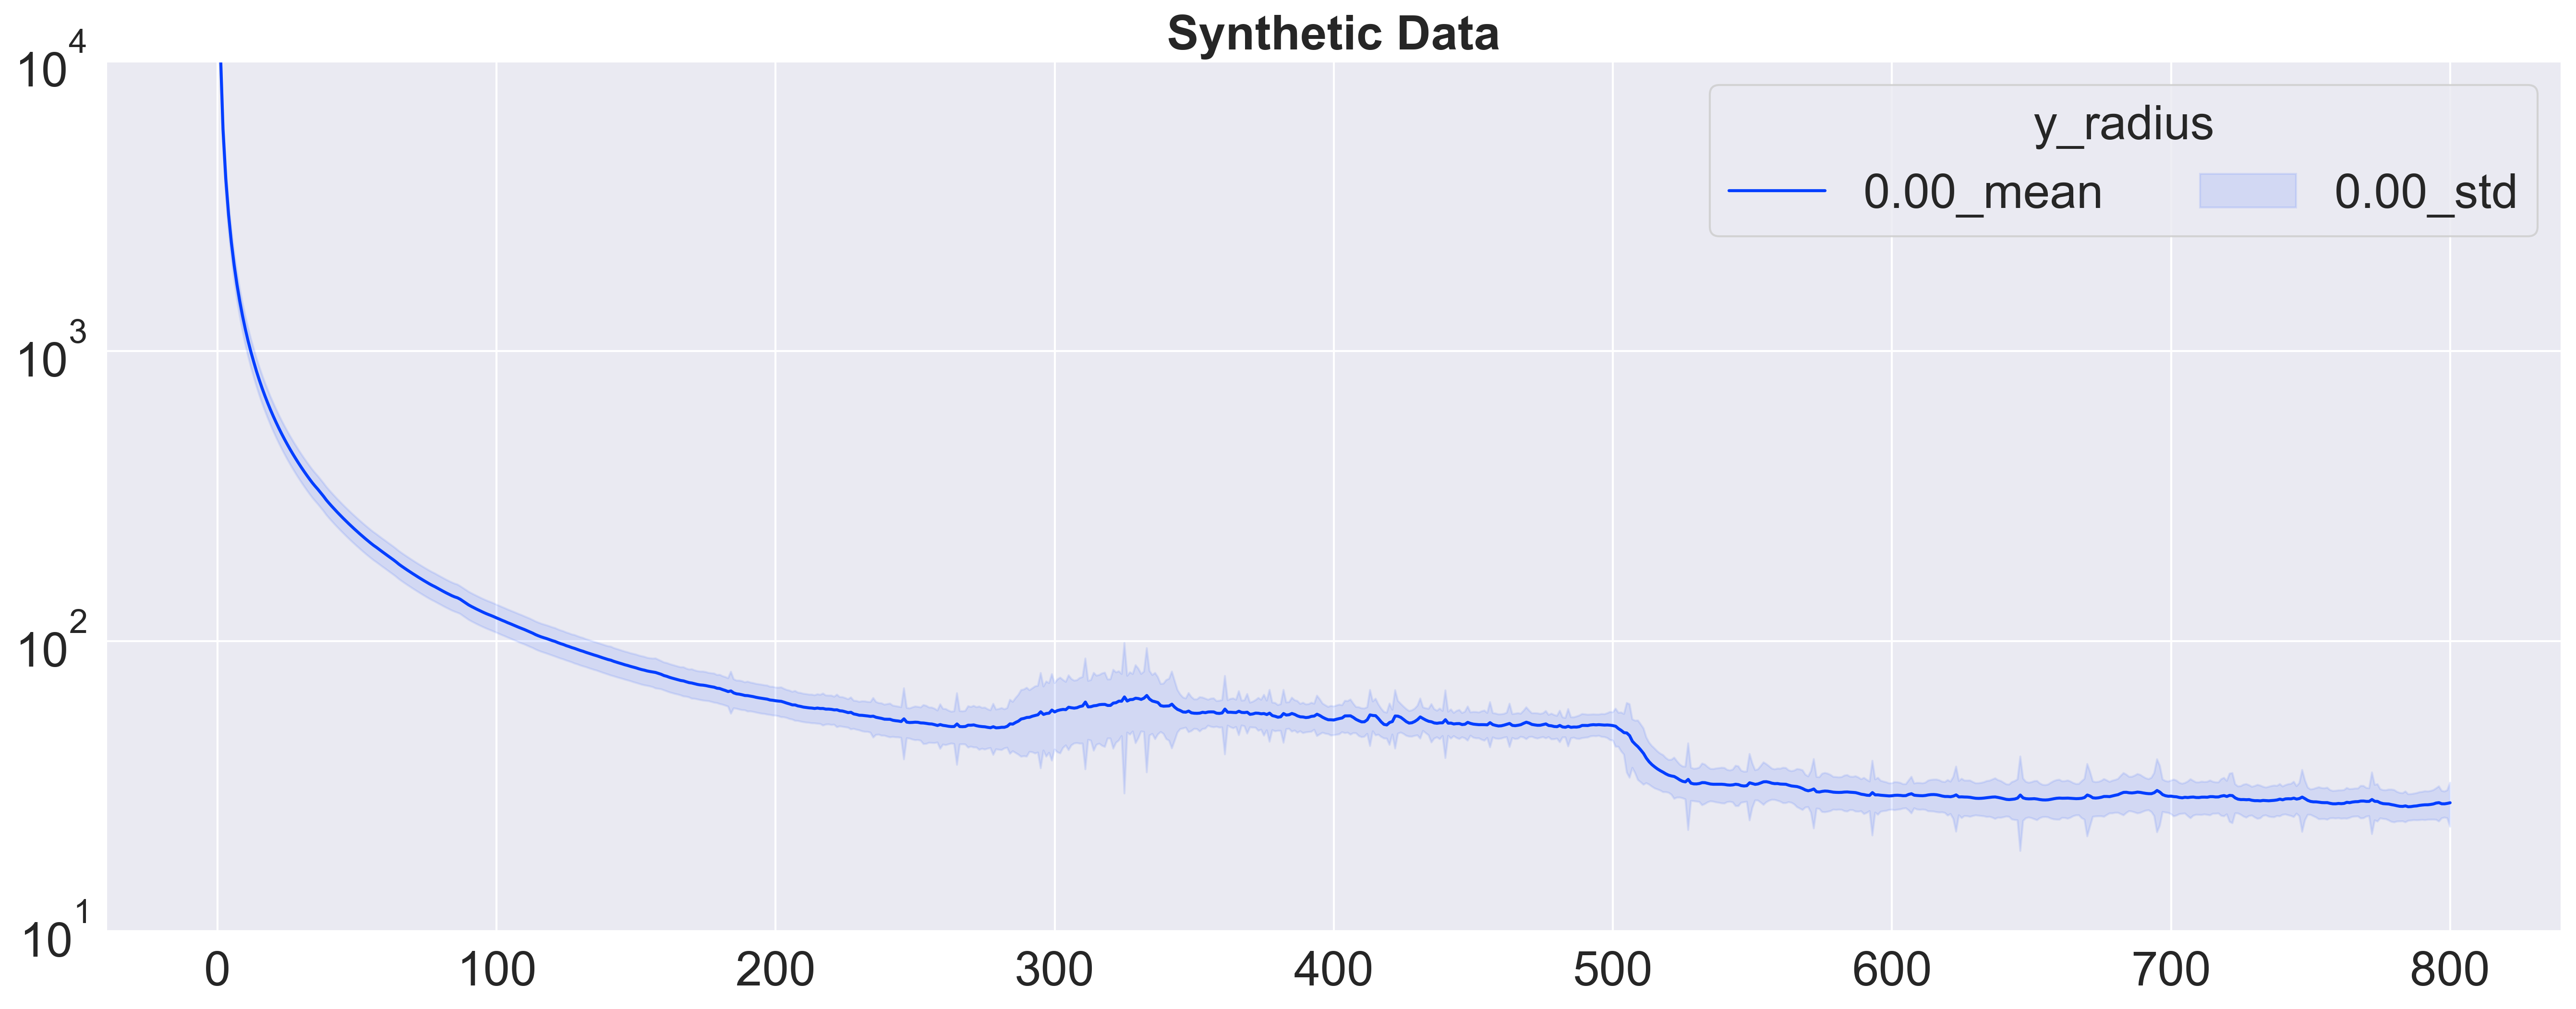

In [14]:
# we only select pristine examples with no defect
target_idx = 0
target = list(ctr.keys())[target_idx]

fig = plot_classwise_dist(df=df_syn[df_syn[target_col]==target])
fig.gca().legend(ncol=2, loc='best', title=target_col)
plt.yscale("log")
plt.ylim(10,10000)
plt.title("Synthetic Data")

Text(0.5, 1.0, 'Real World Data')

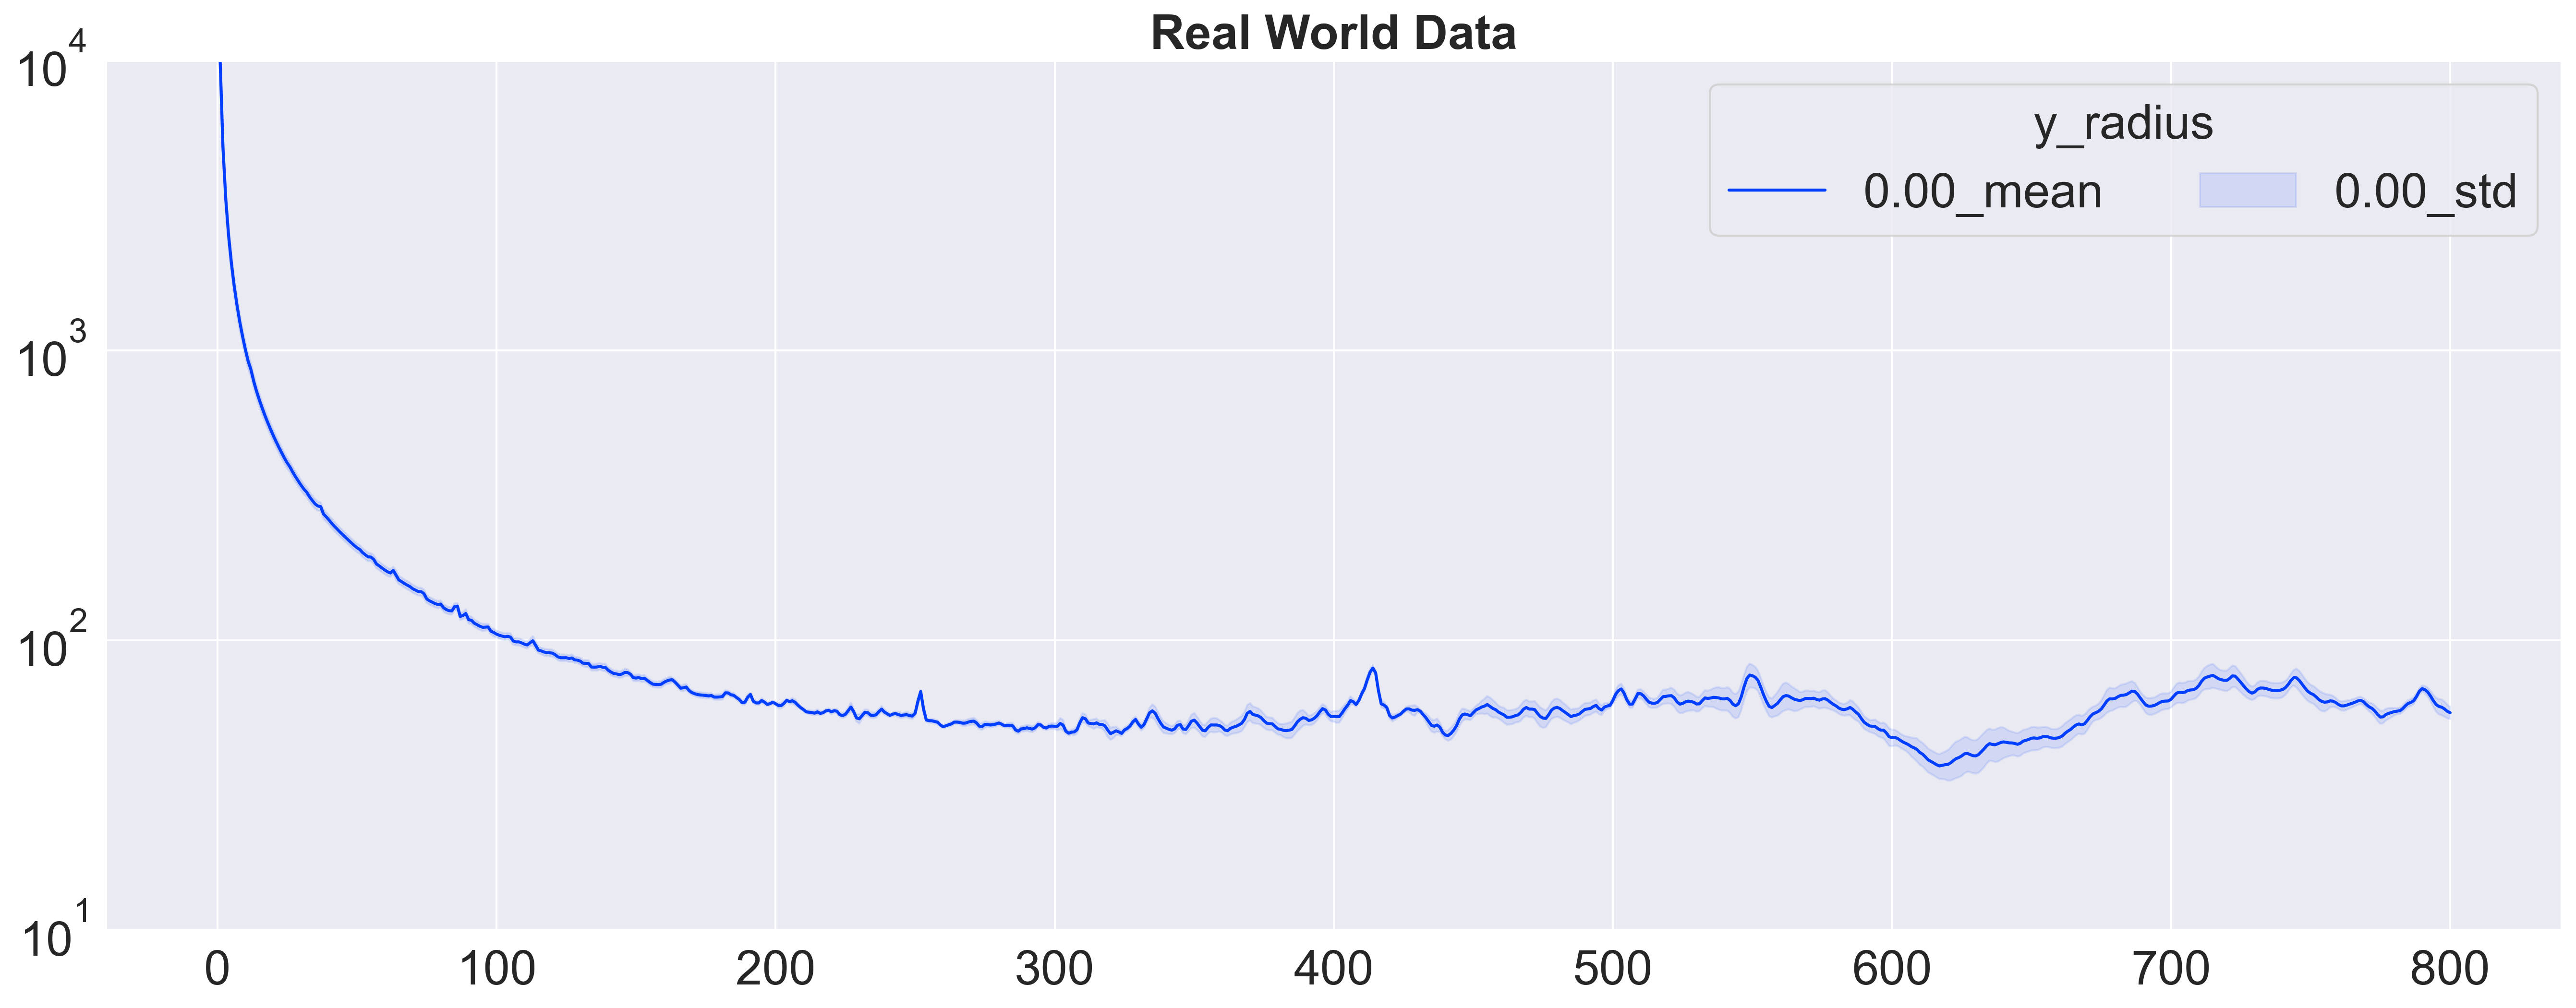

In [15]:
fig = plot_classwise_dist(df=df_real[df_real[target_col]==target])
fig.gca().legend(ncol=2, loc='best', title=target_col)
plt.yscale("log")
plt.ylim(10,10000)
plt.title("Real World Data")

# Compute Calibration
For now, we simply calibrate according to the mean values of the samples without any defect.

In [16]:
mean_spec_syn = df_syn.drop(columns=target_col)[df_syn[target_col]==target].mean(axis=0)
mean_spec_syn.shape

(801,)

In [17]:
mean_spec_real = df_real.drop(columns=target_col)[df_real[target_col]==target].mean(axis=0)
mean_spec_real.shape

(801,)

In [18]:
mean_spec_diff = mean_spec_syn-mean_spec_real
mean_spec_diff.shape

(801,)

# Visualize Calibration Result
As can be seen, the mean values of both real world and synthetic data are aligned after calibration.

In [19]:
x = np.linspace(start=0.004, stop=60.0, num=801)

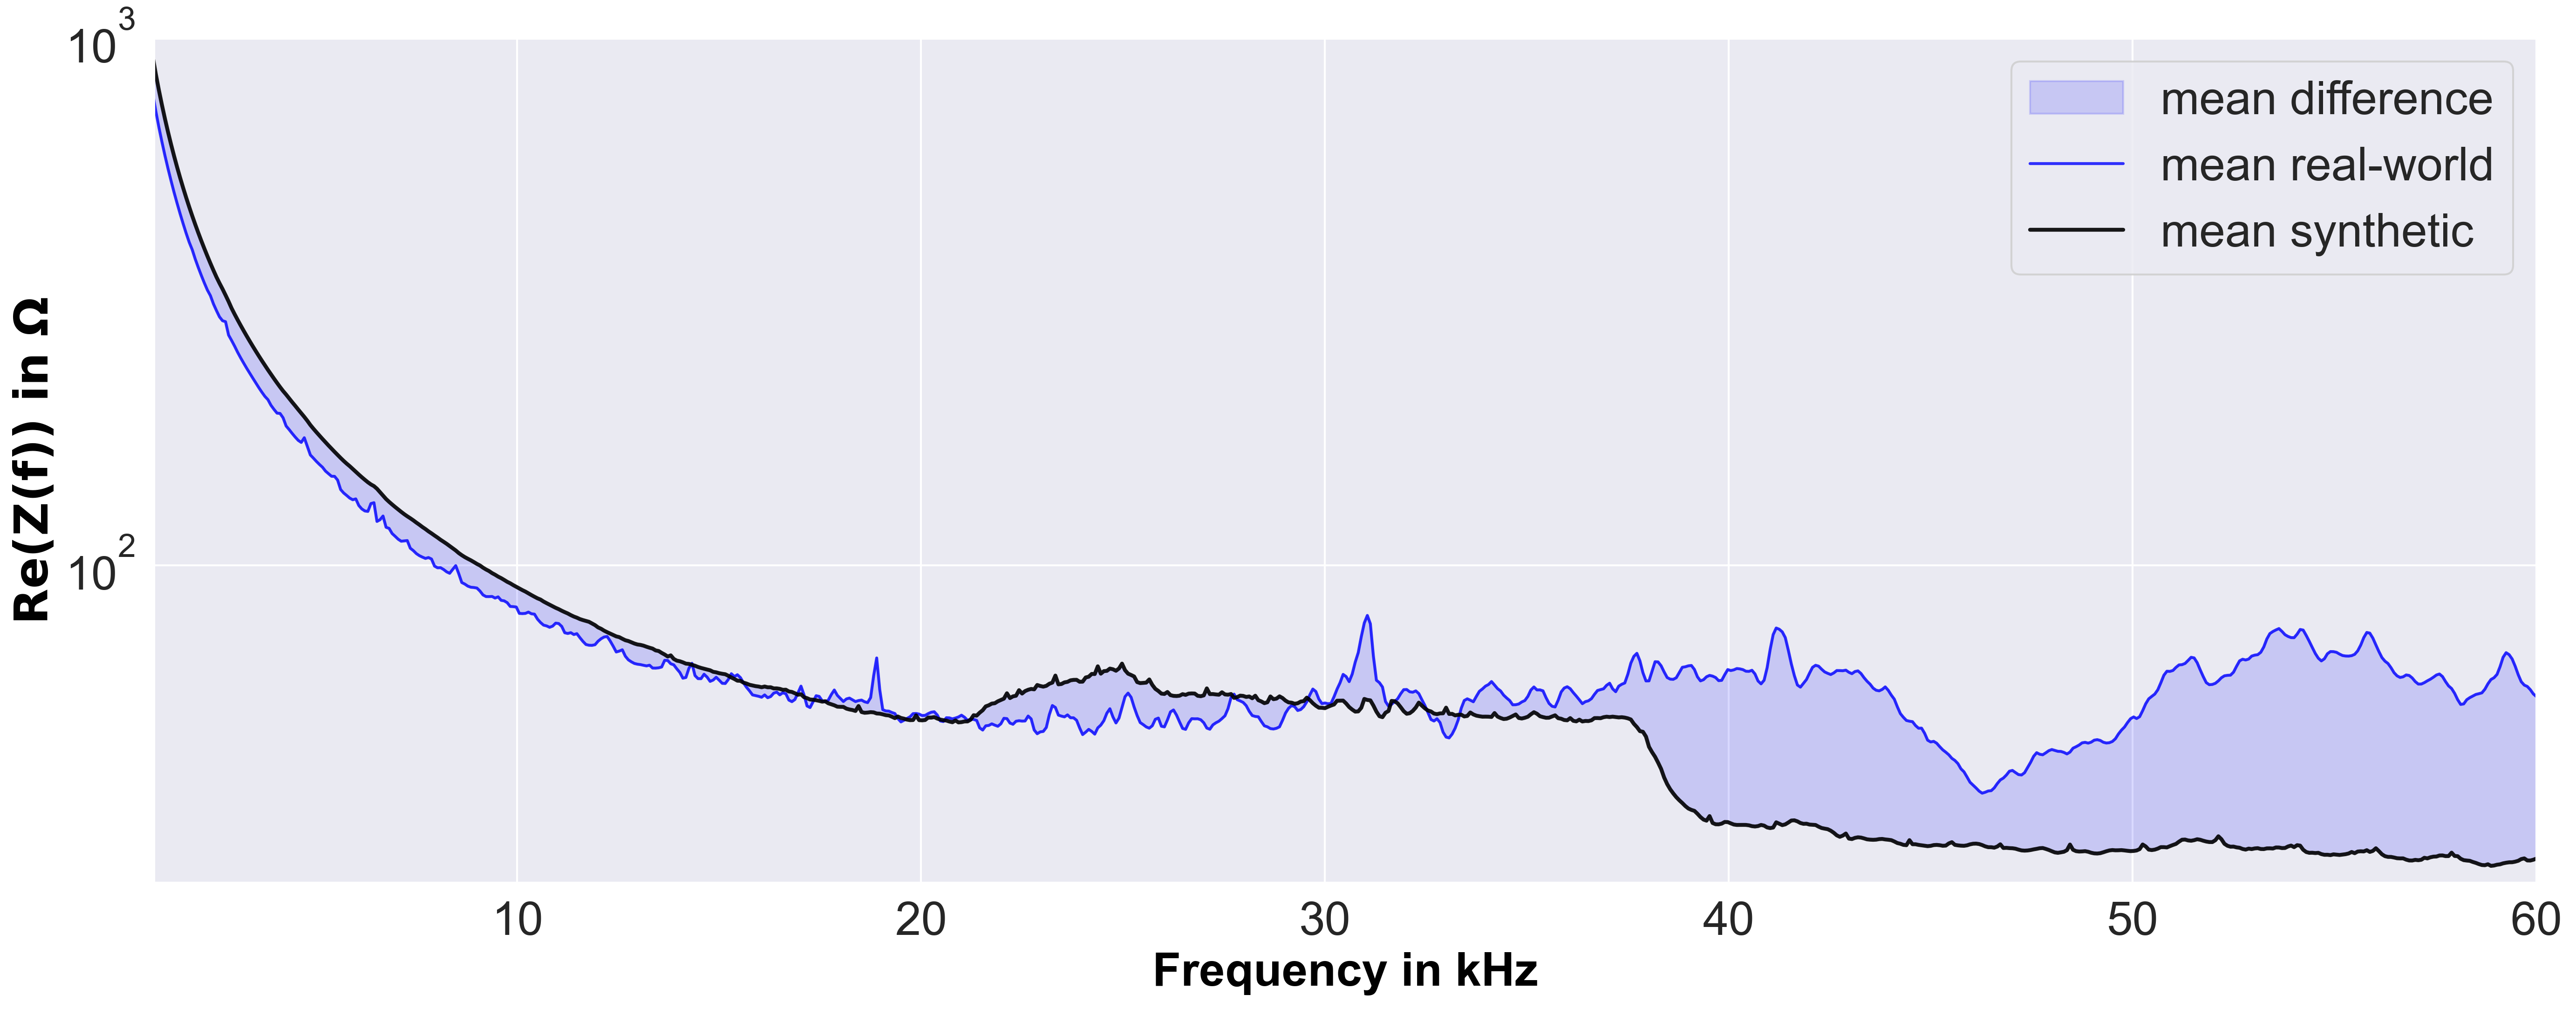

In [20]:
axis_font = {#'family': 'Times',
        'color':  'black',
        'weight': 'bold',
        'size': 24,
        }


plt.fill_between(x, mean_spec_syn, mean_spec_real, color='blue', alpha=.15, label='mean difference')
plt.plot(x, mean_spec_real, color='blue', label='mean real-world', alpha=0.8)
plt.plot(x, mean_spec_real+mean_spec_diff, linewidth=2, color='black', label='mean synthetic', alpha=0.9)
plt.yscale("log")
plt.ylim(25, 1000)
plt.xlim(1, 60)

plt.legend()

plt.xlabel("Frequency in kHz", fontdict=axis_font)
plt.ylabel("$\mathbf{Re(Z(f))~in~\Omega}$", fontdict=axis_font)

fname = Path(RESULT_PATH, r"calibration.pdf")
plt.savefig(fname, bbox_inches='tight')
plt.show()

# Store Calibration Data

In [21]:
mean_spec_diff.to_pickle(CALIBRATION_FILE)